In [14]:
# Import libraries.
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers

### **Loading and preprocessing the dataset.**

This section of the code is dedicated to loading and preparing the **Fashion MNIST dataset** comprising `28x28` grayscale images of clothing.

**The process involves:**

- Loading the dataset split into training and testing sets to evaluate the model's performance.
-  Preprocessing the images by normalizing pixel values.
- Converting the labels into a one-hot encoded format, which is a standard format for categorical labels.
- Shuffling the training data to ensure the model does not learn anything from the order of the samples.
- Batching the data to feed it to the model in manageable sizes during training.
- Prefetching the data for efficient loading, reducing the I/O blocking during training operations.


In [15]:
# Supervised format – we have input and label pairs.
train_ds, test_ds = tfds.load('fashion_mnist', split=['train', 'test'], as_supervised=True)

def preprocess_dataset(dataset):
    # One-hot encode the labels; expect a fixed length for the output.
    dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # Normalize the image pixel values from [0, 255] to [0, 1].
    dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32) / 255.0, target))
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

training_ds = train_ds.apply(preprocess_dataset)
testing_ds = test_ds.apply(preprocess_dataset)

### **Defining a custom model for image classification task.**

We define a custom model for image classification task using Keras API. The model architecture is designed to process `28x28` grayscale images from the **Fashion MNIST** aiming to **classify them into one of 10 categories**. The use of *batch normalization*, *dropout*, and *L2 regularization* is intended to create a model that generalizes well and is less likely to overfit to the training data:

- **Convolutional layers:** We use `Conv2D` layers with `ReLU` activation to extract features from the input images. Each layer uses a specific number of filters (e.g., `32`, `64`, `128`) with a kernel size of `(3, 3)`, and `L2`
regularization to mitigate overfitting.

- **Batch normalization:** These layers are used after convolutions to stabilize learning and normalize the activations of the previous layer, which can lead to faster convergence.

- **Max pooling:** `MaxPooling2D` layers reduce the spatial dimensions of the output from the convolutional layers, which helps to make the model more robust to variations in the position of features in the input images.

- **Dropout:** This is a form of regularization that helps prevent overfitting by randomly setting a fraction of input units to `0` at each update during training.

- **Flattening:** We flatten the `3D` output of the convolutional layers to a `1D` vector before passing it to the dense layers, which is necessary because dense layers expect `1D` inputs.

- **Dense layers:** These are fully connected layers that interpret the features extracted by the convolutional layers. The final dense layer uses a `softmax` activation function to output a probability distribution over the 10 classes.

In [16]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.layers_list = [
            # First convolutional layer with L2 regularization to prevent overfitting.
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
                          kernel_regularizer=tf.keras.regularizers.l2(0.001), input_shape=(28, 28, 1)),
            # Batch normalization to normalize the activations and speed up the training.
            layers.BatchNormalization(),
            # Second convolutional layer with increased filters for more complex feature extraction.
            layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same',
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
            layers.BatchNormalization(),
            # Max pooling to reduce spatial dimensions of the output volume.
            layers.MaxPooling2D(pool_size=(2,2)),
            # Dropout for regularization by randomly setting a fraction of input units to 0.
            layers.Dropout(0.20),

            # Repeating the pattern of convolution, batch normalization, and dropout for deeper feature extraction.
            layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same',
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
            layers.BatchNormalization(),
            layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same',
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2,2)),
            layers.Dropout(0.30),

            # Further increasing the depth for more advanced feature learning.
            layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same',
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
            layers.BatchNormalization(),
            layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding='same',
                                      kernel_regularizer=tf.keras.regularizers.l2
                                      ),
            layers.BatchNormalization(),
            layers.MaxPooling2D(pool_size=(2,2)),
            layers.Dropout(0.40),

            # Flatten the output to feed into dense layers.
            layers.Flatten(),
            # Dense layers for classification, ending with a softmax for probability distribution among classes.
            layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),
            layers.Dropout(0.30),
            layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2()),
            layers.Dropout(0.20),
            layers.Dense(10, activation='softmax')
        ]

    # The forward pass.
    def call(self, x, training=False):
        for layer in self.layers_list:
            x = layer(x, training=training)
        return x

### **Defining a training step.**

In the training step function, we are updating the model with each batch of data. The `GradientTape` tracks and enables the calculation of gradients for optimization. The model makes predictions, calculates loss, and evaluates batch accuracy. We aim to minimize the loss and improve accuracy over training epochs.

In [17]:
# Define a single training step for the model.
def train_step(model, inputs, targets, loss_function, optimizer):
    with tf.GradientTape() as tape:
        # Make predictions for a batch and calculate loss.
        predictions = model(inputs, training=True)
        loss = loss_function(targets, predictions)
        # Calculate batch accuracy.
        correct_predictions = tf.equal(tf.argmax(predictions, 1), tf.argmax(targets, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    # Compute gradients and update model parameters.
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, accuracy

# Define a function to test the model's performance on a dataset.
def test(model, dataset, loss_function):
    test_loss_aggregator = []
    test_accuracy_aggregator = []
    for inputs, targets in dataset:
        # Make predictions and calculate loss for each batch.
        predictions = model(inputs, training=False)
        loss = loss_function(targets, predictions)
        # Calculate batch accuracy.
        correct_predictions = tf.equal(tf.argmax(predictions, 1), tf.argmax(targets, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
        # Aggregate loss and accuracy.
        test_loss_aggregator.append(loss.numpy())
        test_accuracy_aggregator.append(accuracy.numpy())
    # Compute average loss and accuracy over the dataset.
    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)
    return test_loss, test_accuracy  # Corrected to return both metrics

# Reset the state of the TensorFlow backend.
tf.keras.backend.clear_session()

# Hyperparameters setup.
num_epochs = 10
learning_rate = 0.1

# Track start time.
start = time.time()

# Initialize the model.
model = Model()
# Loss function and optimizer setup.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Lists for tracking training and testing performance.
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training and testing loop.
for epoch in range(num_epochs):
    epoch_loss_agg = []
    epoch_acc_agg = []
    # Train on each batch.
    for inputs, targets in training_ds:
        train_loss, train_accuracy = train_step(model, inputs, targets, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss.numpy())
        epoch_acc_agg.append(train_accuracy.numpy())

    # Calculate and store average loss and accuracy for the epoch.
    avg_train_loss = np.mean(epoch_loss_agg)
    avg_train_accuracy = np.mean(epoch_acc_agg)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Evaluate the model on the test dataset.
    test_loss, test_accuracy = test(model, testing_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch}, Train Loss: {np.mean(epoch_loss_agg)}, Train Accuracy: {np.mean(epoch_acc_agg)}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

# Calculate total execution time.
end = time.time()
execution_time = int((end - start)/60)

print(f'Execution time: {execution_time} minutes and {execution_time % 60} seconds.')

Epoch 0, Train Loss: 0.6214262843132019, Train Accuracy: 0.7768499851226807, Test Loss: 1.4859017133712769, Test Accuracy: 0.5862619876861572
Epoch 1, Train Loss: 0.39101794362068176, Train Accuracy: 0.8578833341598511, Test Loss: 0.35522252321243286, Test Accuracy: 0.8686102032661438
Epoch 2, Train Loss: 0.32657650113105774, Train Accuracy: 0.880649983882904, Test Loss: 0.28388407826423645, Test Accuracy: 0.8968650102615356
Epoch 3, Train Loss: 0.2924058735370636, Train Accuracy: 0.8945833444595337, Test Loss: 0.2633475363254547, Test Accuracy: 0.9089456796646118
Epoch 4, Train Loss: 0.26709961891174316, Train Accuracy: 0.9042333364486694, Test Loss: 0.24018160998821259, Test Accuracy: 0.9138378500938416
Epoch 5, Train Loss: 0.24868789315223694, Train Accuracy: 0.9092666506767273, Test Loss: 0.253946989774704, Test Accuracy: 0.9085463285446167
Epoch 6, Train Loss: 0.231057271361351, Train Accuracy: 0.9157166481018066, Test Loss: 0.22775602340698242, Test Accuracy: 0.9212260246276855
E

### **Adding visualization.**

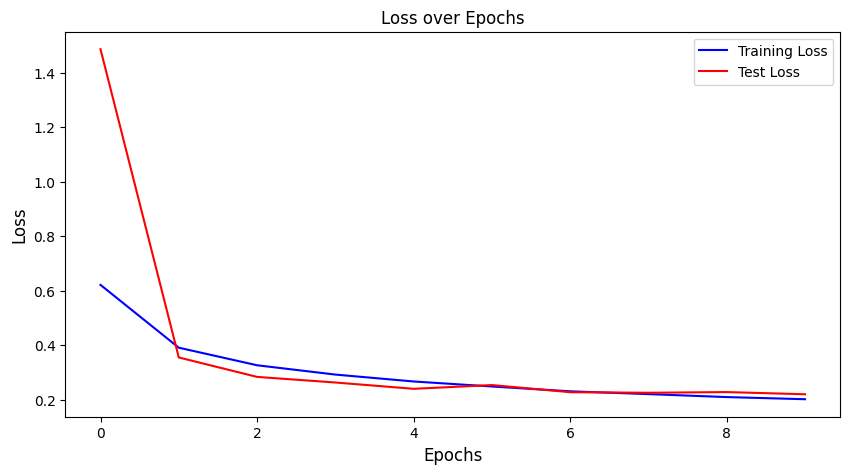

In [18]:
# Plotting loss over epochs.
plt.figure(figsize=(10, 5))
plt.plot(train_losses, color='blue', label='Training Loss')
plt.plot(test_losses, color='red', label='Test Loss')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title('Loss over Epochs')
plt.legend()
plt.show()

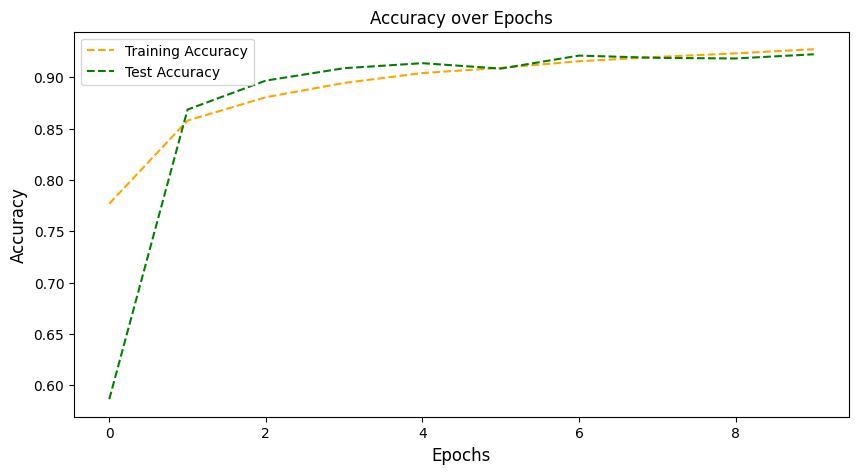

In [19]:
# Plotting accuracy over epochs.
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, linestyle='dashed', color='orange', label='Training Accuracy')
plt.plot(test_accuracies, linestyle='dashed', color='green', label='Test Accuracy')
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()